In [19]:
import os
import numpy as np
import pandas as pd
import xgboost
import xgboost as xgb
import optuna
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error 
import json


import joblib

logical_cores = os.cpu_count()
print(f"Number of logical CPU cores: {logical_cores}")

num_workers = max(1, logical_cores // 2)
print(f"Number of workers set to: {num_workers}")

def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

gpu_available = is_gpu_available()
print(f"GPU available: {gpu_available}")

print(xgboost.build_info())

Number of logical CPU cores: 16
Number of workers set to: 8
GPU available: True
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 4], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 3, 2], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'C:\\Users\\ng_mi\\Anaconda\\envs\\pytorch-gpu\\Lib\\site-packages\\xgboost\\lib\\xgboost.dll'}


In [20]:
os.makedirs('../feature-importances/xbclassifier', exist_ok=True)
os.makedirs('../feature-importances/xbregressor', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbregressor', exist_ok=True)


path = '../data/train'

ticker_list = []

if os.path.exists(path):
    ticker_list = [os.path.splitext(f)[0] for f in os.listdir(path) if f.endswith('.csv')]


In [21]:
def load_or_create_ticker_df(csv_file_path):
    """
    Load the existing ticker DataFrame from a CSV file if it exists,
    otherwise create a new DataFrame with predefined column types.
    Ensure the DataFrame has the specified columns, add any missing columns,
    and rearrange the columns in alphabetical order, excluding 'Ticker_Symbol'.

    Args:
    csv_file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded or newly created DataFrame.
    """
    # Define the column types
    column_types = {
        "Ticker_Symbol": str,
        "Best_Cov1D_Classification_Accuracy": float,
        "Best_Cov1D_Classification_Path": str,
        "Best_Cov1D_Regression_RMSE": float,
        "Best_Cov1D_Regression_Path": str,
        "Best_LSTM_Classification_Accuracy": float,
        "Best_LSTM_Classification_Path": str,
        "Best_LSTM_Regression_RMSE": float,
        "Best_LSTM_Regression_Path": str,
        "Best_Transformer_Classification_Accuracy": float,
        "Best_Transformer_Classification_Path": str,
        "Best_Transformer_Regression_RMSE": float,
        "Best_Transformer_Regression_Path": str,
        "Best_XGBClassifier_Classification_Accuracy": float,
        "Best_XGBClassifier_Classification_Path": str,
        "Best_XGBRegressor_Regression_RMSE": float,
        "Best_XGBRegressor_Regression_Path": str
    }


    if os.path.isfile(csv_file_path):
        # Load the existing file into a DataFrame
        ticker_df = pd.read_csv(csv_file_path)
        
        # Ensure all specified columns are present
        for column, dtype in column_types.items():
            if column not in ticker_df.columns:
                ticker_df[column] = pd.Series(dtype=dtype)
        
        # Reorder columns alphabetically, excluding 'Ticker_Symbol'
        columns = ["Ticker_Symbol"] + sorted([col for col in ticker_df.columns if col != "Ticker_Symbol"])
        ticker_df = ticker_df[columns]
    else:
        # Create a new DataFrame with the specified column types
        ticker_df = pd.DataFrame(columns=column_types.keys()).astype(column_types)
    
    return ticker_df

In [22]:
def delete_hyperparameter_search_model(ticker_symbol, model_type):
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    xbclassifier_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    xbregressor_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    xbclassifier_params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    xbregressor_params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'

    if model_type == "xbclassifier":
        if os.path.isfile(xbclassifier_model_path):
            os.remove(xbclassifier_model_path)
            print(f"Deleted {xbclassifier_model_path}")
        if os.path.isfile(xbclassifier_params_path):
            os.remove(xbclassifier_params_path)
            print(f"Deleted {xbclassifier_params_path}")
    
    if model_type == "xbregressor":
        if os.path.isfile(xbregressor_model_path):
            os.remove(xbregressor_model_path)
            print(f"Deleted {xbregressor_model_path}")
        if os.path.isfile(xbregressor_params_path):
            os.remove(xbregressor_params_path)
            print(f"Deleted {xbregressor_params_path}")

    if os.path.isfile(csv_path):
        ticker_df = pd.read_csv(csv_path)
        if ticker_symbol in ticker_df['Ticker_Symbol'].values:
            if model_type == "xbclassifier":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [pd.NA, pd.NA]
            if model_type == "xbregressor":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [pd.NA, pd.NA]
            ticker_df.to_csv(csv_path, index=False)
            print(f"Deleted {ticker_symbol} from {csv_path}")
        else:
            print(f"{ticker_symbol} not found in {csv_path}")
    else:
        print(f"{csv_path} does not exist")


In [23]:
def training_preprocess_data(df):
    if df.isna().sum().sum() > 0 or df.isin([float('inf'), float('-inf')]).sum().sum() > 0:
        df = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

    df = df.dropna()

    columns_to_drop = [
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ]
    X = df.drop(columns=columns_to_drop)

    # Define the list of specific columns to keep
    columns_to_keep = [
        'RSI', 'EMA', 'ADX', 'PATTERN_SUM'
    ]
    
    # Select only the specified columns
    #X = df[columns_to_keep]
    
    y_classifier = (np.sign(df['DAILY_MIDPRICE_CHANGE']) >= 0).astype(int)
    y_regressor = df['DAILY_MIDPRICE_CHANGE']

    return X, y_classifier, y_regressor

In [24]:
def xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")
    
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'use_label_encoder': False,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, preds)
        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBClassifier_Classification_Accuracy'].values[0]
        if pd.isnull(current_score) or study.best_value > current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")
            
             # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model accuracy: {current_score} is better for {ticker_symbol} than accuracy: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [study.best_value], 'Best_XGBClassifier_Classification_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"Parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")

    if hyperparameter_search:
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)

    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    # Assuming X and y are your features and labels respectively
    X_train = X[::2]  # Odd-numbered rows (0-based index)
    X_valid = X[1::2]  # Even-numbered rows (0-based index)
    y_train = y[::2]  # Corresponding labels for odd-numbered rows
    y_valid = y[1::2]  # Corresponding labels for even-numbered rows

    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBClassifier(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy for {ticker_symbol}: {accuracy:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [accuracy, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [accuracy], 'Best_XGBClassifier_Classification_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with accuracy: {accuracy:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)
  
    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [25]:
def xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")
        
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        rmse = root_mean_squared_error (y_valid, preds)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params.update(study.best_trial.params)

    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBRegressor_Regression_RMSE'].values[0]
        if pd.isnull(current_score) or study.best_value < current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")

            # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model MSE: {current_score} is better for {ticker_symbol} than MSE: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [study.best_value], 'Best_XGBRegressor_Regression_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")

    if hyperparameter_search:
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        
    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    # Assuming X and y are your features and labels respectively
    X_train = X[::2]  # Odd-numbered rows (0-based index)
    X_valid = X[1::2]  # Even-numbered rows (0-based index)
    y_train = y[::2]  # Corresponding labels for odd-numbered rows
    y_valid = y[1::2]  # Corresponding labels for even-numbered rows

    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBRegressor(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    rmse = root_mean_squared_error (y_valid, preds)
    
    print(f"Validation RSME for {ticker_symbol}: {rmse:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [rmse, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [rmse], 'Best_XGBRegressor_Regression_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with RSME: {rmse:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)

    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [26]:
for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/train/{ticker_symbol}.csv")
    X, y_classifier, y_regressor = training_preprocess_data(dataframe)
    xbclassifier_resume_training(X, y_classifier, gpu_available, ticker_symbol, True, True)
    xbregressor_resume_training(X, y_regressor, gpu_available, ticker_symbol, True, True)


[I 2024-09-10 17:22:15,667] A new study created in memory with name: no-name-155edd79-d6d2-4d36-8f30-1512b1c5a571


Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:22:16,103] Trial 0 finished with value: 0.7784090909090909 and parameters: {'n_estimators': 898, 'max_depth': 9, 'learning_rate': 0.2557645892248885, 'subsample': 0.9061786822596595, 'colsample_bytree': 0.7525446111828127, 'gamma': 0.734614356225769, 'lambda': 1.0032398115942162e-08, 'alpha': 0.04111341990552682}. Best is trial 0 with value: 0.7784090909090909.
[I 2024-09-10 17:22:16,430] Trial 1 finished with value: 0.7443181818181818 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.2632576795493569, 'subsample': 0.7083797617776286, 'colsample_bytree': 0.9779071902098263, 'gamma': 1.0207346334777279, 'lambda': 3.7042185577823476e-05, 'alpha': 0.008428922286334939}. Best is trial 0 with value: 0.7784090909090909.
[I 2024-09-10 17:22:16,723] Trial 2 finished with value: 0.7613636363636364 and parameters: {'n_estimators': 416, 'max_depth': 5, 'learning_rate': 0.2810422891085895, 'subsample': 0.9549325886226832, 'colsample_bytree': 0.9316785480539

Model for CL=F saved with accuracy: 0.8125
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-10 17:23:03,140] A new study created in memory with name: no-name-72ae916d-f27e-4db6-8a78-848ce3665b41


Validation accuracy for CL=F: 0.8125
Model for CL=F saved with accuracy: 0.8125
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:23:03,401] Trial 0 finished with value: 1.075531708091736 and parameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.18921794399358483, 'subsample': 0.6553540337633292, 'colsample_bytree': 0.8028754483957271, 'gamma': 4.009328289096147, 'lambda': 3.013504721850348e-08, 'alpha': 1.4803123299313119e-08}. Best is trial 0 with value: 1.075531708091736.
[I 2024-09-10 17:23:03,928] Trial 1 finished with value: 1.1044884205596903 and parameters: {'n_estimators': 485, 'max_depth': 9, 'learning_rate': 0.06589666434035323, 'subsample': 0.6622582603518627, 'colsample_bytree': 0.6943443653463633, 'gamma': 2.380764116603781, 'lambda': 1.2336269620754144e-06, 'alpha': 4.818854659940957e-06}. Best is trial 0 with value: 1.075531708091736.
[I 2024-09-10 17:23:04,193] Trial 2 finished with value: 1.133814655509752 and parameters: {'n_estimators': 463, 'max_depth': 3, 'learning_rate': 0.24882072267290983, 'subsample': 0.5994518953744719, 'colsample_bytree': 0.6006709845859

Best model for CL=F saved with RMSE: 1.0183554439809628
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-10 17:23:46,863] A new study created in memory with name: no-name-79093c32-83a1-4ac5-965f-4df4a1412fd5


Validation RSME for CL=F: 1.0184
Model for CL=F saved with RSME: 1.0184
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:23:47,117] Trial 0 finished with value: 0.6742857142857143 and parameters: {'n_estimators': 574, 'max_depth': 9, 'learning_rate': 0.14277696444422214, 'subsample': 0.7558474081400728, 'colsample_bytree': 0.8469257219853541, 'gamma': 0.3985689859896002, 'lambda': 0.050132379981203755, 'alpha': 0.47363694368746956}. Best is trial 0 with value: 0.6742857142857143.
[I 2024-09-10 17:23:47,317] Trial 1 finished with value: 0.6514285714285715 and parameters: {'n_estimators': 610, 'max_depth': 4, 'learning_rate': 0.28839444374324164, 'subsample': 0.6781523634438972, 'colsample_bytree': 0.7847749694964732, 'gamma': 3.260454820807361, 'lambda': 0.051489950948096816, 'alpha': 0.0054952804413178034}. Best is trial 0 with value: 0.6742857142857143.
[I 2024-09-10 17:23:47,563] Trial 2 finished with value: 0.6742857142857143 and parameters: {'n_estimators': 586, 'max_depth': 7, 'learning_rate': 0.13228967440718145, 'subsample': 0.9906140644522843, 'colsample_bytree': 0.75646686349340

Model for NVDA saved with accuracy: 0.72
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-10 17:24:32,913] A new study created in memory with name: no-name-e5201dba-6b86-4119-9460-4d771654617f


Validation accuracy for NVDA: 0.7200
Model for NVDA saved with accuracy: 0.7200
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:24:33,202] Trial 0 finished with value: 1.0997468048713157 and parameters: {'n_estimators': 807, 'max_depth': 4, 'learning_rate': 0.15126070771711245, 'subsample': 0.6705053152632497, 'colsample_bytree': 0.9224285970919421, 'gamma': 1.7042914615296123, 'lambda': 0.002853569726437476, 'alpha': 2.109434814597846e-08}. Best is trial 0 with value: 1.0997468048713157.
[I 2024-09-10 17:24:33,452] Trial 1 finished with value: 1.155849358859389 and parameters: {'n_estimators': 680, 'max_depth': 3, 'learning_rate': 0.10609392890762918, 'subsample': 0.7626529357989869, 'colsample_bytree': 0.8757338273190975, 'gamma': 1.3330118410481417, 'lambda': 6.923261890380987e-08, 'alpha': 2.5261387669686436e-05}. Best is trial 0 with value: 1.0997468048713157.
[I 2024-09-10 17:24:33,725] Trial 2 finished with value: 1.1557864442269339 and parameters: {'n_estimators': 639, 'max_depth': 10, 'learning_rate': 0.22152039830515932, 'subsample': 0.5091620274501942, 'colsample_bytree': 0.812135057

Best model for NVDA saved with RMSE: 1.061623092676544
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-10 17:25:13,778] A new study created in memory with name: no-name-d11ab20d-9abc-4392-a6f7-bb27ba6049ac


Validation RSME for NVDA: 1.0616
Model for NVDA saved with RSME: 1.0616
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:25:14,040] Trial 0 finished with value: 0.5054347826086957 and parameters: {'n_estimators': 625, 'max_depth': 3, 'learning_rate': 0.13971757500700202, 'subsample': 0.9466712603781711, 'colsample_bytree': 0.6467414116838278, 'gamma': 0.9333127512177647, 'lambda': 8.063350618738278e-05, 'alpha': 3.18862510951389e-08}. Best is trial 0 with value: 0.5054347826086957.
[I 2024-09-10 17:25:14,333] Trial 1 finished with value: 0.4891304347826087 and parameters: {'n_estimators': 458, 'max_depth': 5, 'learning_rate': 0.16247389341207125, 'subsample': 0.7828538752944483, 'colsample_bytree': 0.8269486118907132, 'gamma': 1.8525610186416341, 'lambda': 9.193474367025949e-05, 'alpha': 3.133922827790306e-07}. Best is trial 0 with value: 0.5054347826086957.
[I 2024-09-10 17:25:14,700] Trial 2 finished with value: 0.5706521739130435 and parameters: {'n_estimators': 853, 'max_depth': 3, 'learning_rate': 0.1921554285555746, 'subsample': 0.7414006438883135, 'colsample_bytree': 0.70298395401

Model for SGDUSD=X saved with accuracy: 0.625
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-10 17:25:50,570] A new study created in memory with name: no-name-a438702a-2a00-44b3-844b-67211855bbfa


Validation accuracy for SGDUSD=X: 0.6250
Model for SGDUSD=X saved with accuracy: 0.6250
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:25:50,817] Trial 0 finished with value: 0.0017310014379323417 and parameters: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.01622522911376882, 'subsample': 0.8418374084255429, 'colsample_bytree': 0.8674478718147587, 'gamma': 3.369438209761279, 'lambda': 0.0021170612771249, 'alpha': 0.06772714893450854}. Best is trial 0 with value: 0.0017310014379323417.
[I 2024-09-10 17:25:51,074] Trial 1 finished with value: 0.001730343331412726 and parameters: {'n_estimators': 753, 'max_depth': 9, 'learning_rate': 0.043873229505409034, 'subsample': 0.8217463464663317, 'colsample_bytree': 0.9036496134291117, 'gamma': 3.0228631684522584, 'lambda': 0.0009792746475864602, 'alpha': 1.067255439198567e-06}. Best is trial 1 with value: 0.001730343331412726.
[I 2024-09-10 17:25:51,517] Trial 2 finished with value: 0.0017303017028001285 and parameters: {'n_estimators': 349, 'max_depth': 7, 'learning_rate': 0.1546519822895375, 'subsample': 0.979120510883061, 'colsample_bytree': 0.58

Best model for SGDUSD=X saved with RMSE: 0.001728599435540544
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-10 17:26:22,755] A new study created in memory with name: no-name-f80c7c83-0c85-4496-8148-a0b5f28f5c51


Validation RSME for SGDUSD=X: 0.0017
Model for SGDUSD=X saved with RSME: 0.0017
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:26:23,034] Trial 0 finished with value: 0.5380434782608695 and parameters: {'n_estimators': 869, 'max_depth': 3, 'learning_rate': 0.13744380698460756, 'subsample': 0.5997430673377981, 'colsample_bytree': 0.8239604492383741, 'gamma': 0.18546382942517314, 'lambda': 1.6524559190855082e-05, 'alpha': 0.0036923364108550085}. Best is trial 0 with value: 0.5380434782608695.
[I 2024-09-10 17:26:23,351] Trial 1 finished with value: 0.5380434782608695 and parameters: {'n_estimators': 318, 'max_depth': 5, 'learning_rate': 0.15944453233058614, 'subsample': 0.8344683484601774, 'colsample_bytree': 0.8514061076815749, 'gamma': 1.1119505063652346, 'lambda': 0.0001263323708334019, 'alpha': 1.906431866541471e-08}. Best is trial 0 with value: 0.5380434782608695.
[I 2024-09-10 17:26:23,625] Trial 2 finished with value: 0.5380434782608695 and parameters: {'n_estimators': 770, 'max_depth': 9, 'learning_rate': 0.29567008401540606, 'subsample': 0.8772415808482753, 'colsample_bytree': 0.9585790

Model for USDSGD=X saved with accuracy: 0.6195652173913043
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.


[I 2024-09-10 17:26:59,079] A new study created in memory with name: no-name-e10d30e3-af08-443a-98d3-9f46be8673ab


Validation accuracy for USDSGD=X: 0.6196
Model for USDSGD=X saved with accuracy: 0.6196
Feature importances for USDSGD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-10 17:26:59,364] Trial 0 finished with value: 0.0031111004096878794 and parameters: {'n_estimators': 854, 'max_depth': 7, 'learning_rate': 0.19374346127130565, 'subsample': 0.8547805432437618, 'colsample_bytree': 0.8909388969113278, 'gamma': 1.4276782529775915, 'lambda': 7.316206594704106e-05, 'alpha': 0.0027328335975510217}. Best is trial 0 with value: 0.0031111004096878794.
[I 2024-09-10 17:26:59,596] Trial 1 finished with value: 0.003113459837305242 and parameters: {'n_estimators': 355, 'max_depth': 7, 'learning_rate': 0.10998383550058836, 'subsample': 0.9971052363654639, 'colsample_bytree': 0.7004243221437294, 'gamma': 0.4462789777634385, 'lambda': 0.3690998877471511, 'alpha': 0.4910867430711601}. Best is trial 0 with value: 0.0031111004096878794.
[I 2024-09-10 17:26:59,871] Trial 2 finished with value: 0.0031100959475409222 and parameters: {'n_estimators': 441, 'max_depth': 10, 'learning_rate': 0.24700151443668383, 'subsample': 0.9092034001593087, 'colsample_bytree': 0.

Best model for USDSGD=X saved with RMSE: 0.0031091853610114555
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation RSME for USDSGD=X: 0.0031
Model for USDSGD=X saved with RSME: 0.0031
Feature importances for USDSGD=X saved.


CL=F at 2024-06-12 , Actual Price: -0.3199996948242187, xbregressor_result: [-0.25616878], xbclassifier_result: [1], final: [-0.25616878]
CL=F at 2024-06-13 , Actual Price: 0.160003662109375, xbregressor_result: [-0.25616878], xbclassifier_result: [1], final: [-0.25616878]
CL=F at 2024-06-14 , Actual Price: 0.8800010681152344, xbregressor_result: [-0.03524642], xbclassifier_result: [1], final: [-0.03524642]
CL=F at 2024-06-17 , Actual Price: 1.399993896484375, xbregressor_result: [0.523445], xbclassifier_result: [1], final: [0.523445]
CL=F at 2024-06-18 , Actual Price: 1.0500030517578125, xbregressor_result: [0.11912301], xbclassifier_result: [1], final: [0.11912301]
CL=F at 2024-06-20 , Actual Price: -0.7000007629394531, xbregressor_result: [-0.05828589], xbclassifier_result: [1], final: [-0.05828589]
CL=F at 2024-06-21 , Actual Price: -0.0649986267089843, xbregressor_result: [-0.68892026], xbclassifier_result: -1, final: [-0.68892026]
CL=F at 2024-06-24 , Actual Price: 0.220001220703

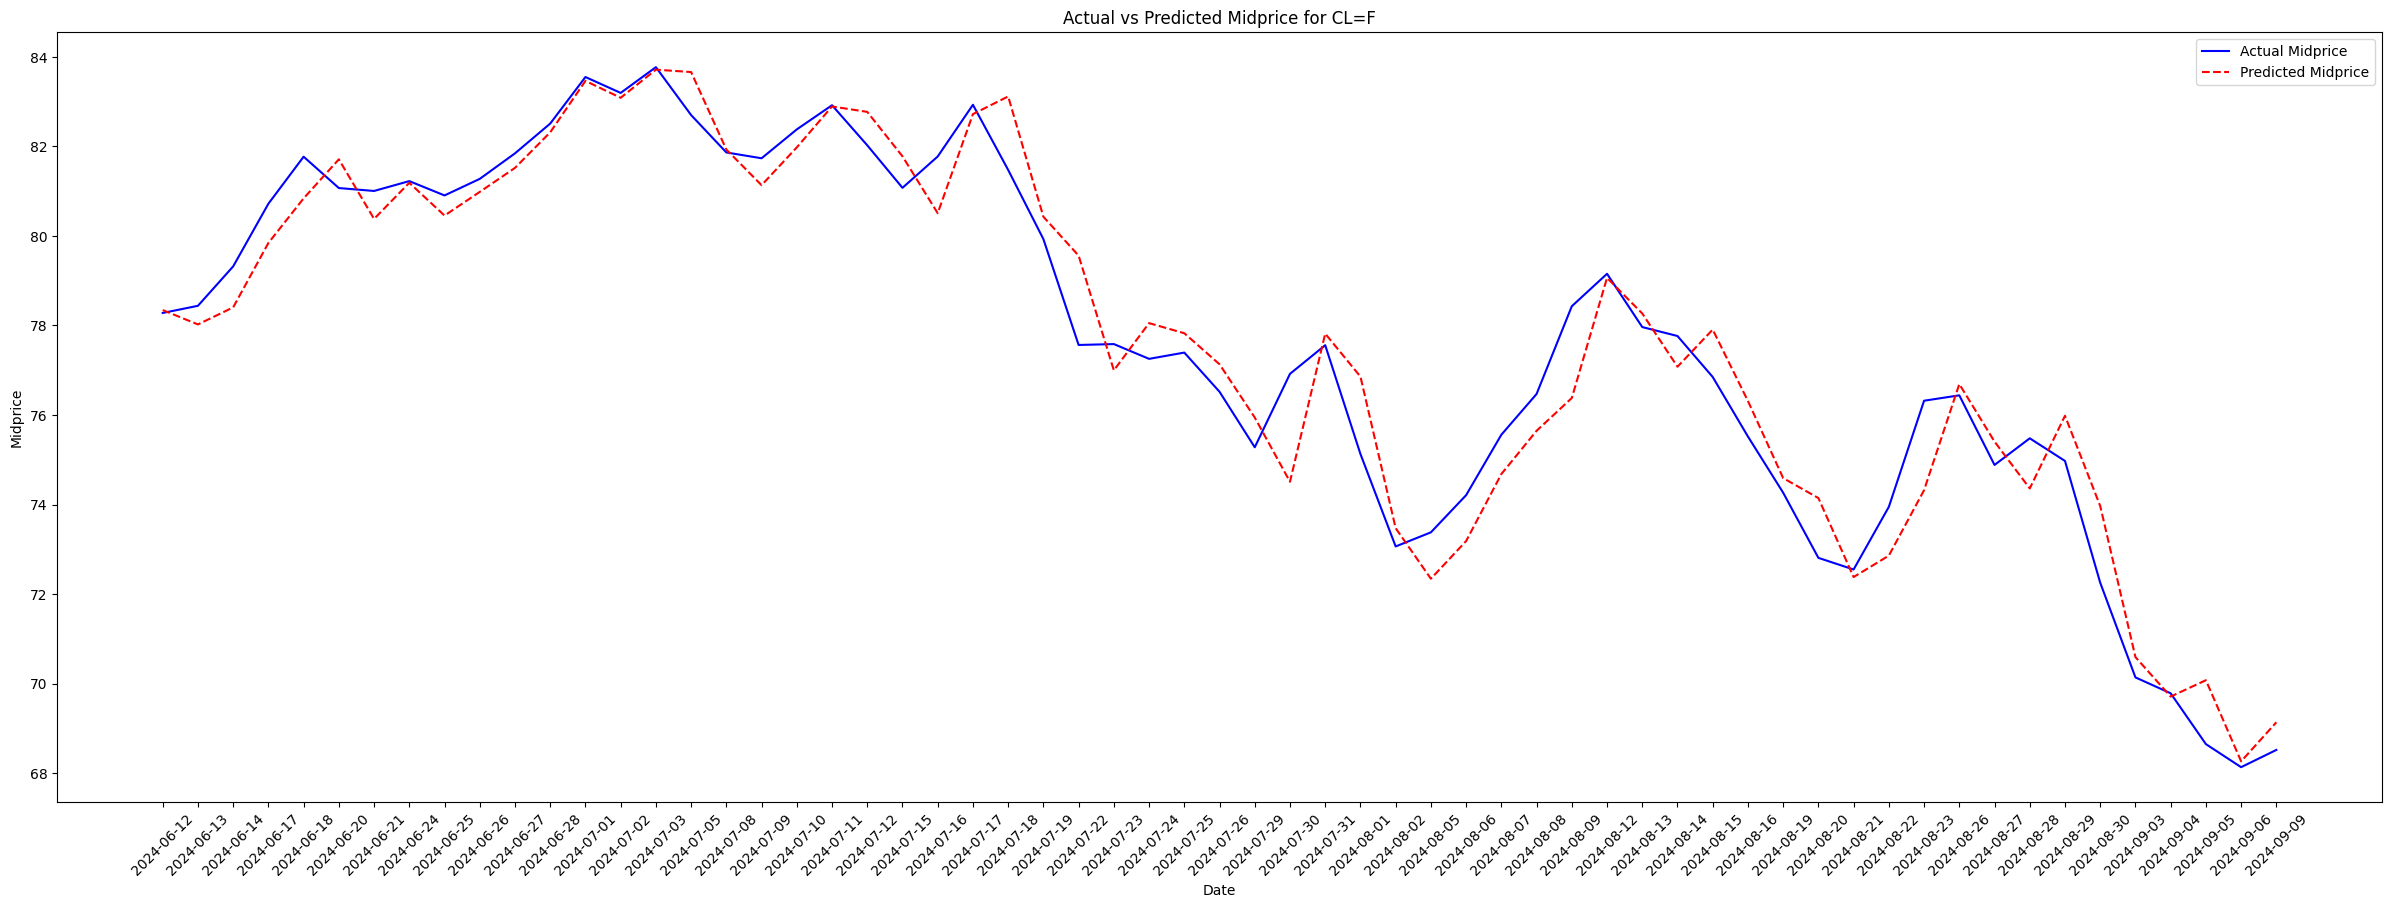

NVDA at 2024-06-11 , Actual Price: 3.919998168945313, xbregressor_result: [0.20810679], xbclassifier_result: [1], final: [0.20810679]
NVDA at 2024-06-12 , Actual Price: 3.7550048828125, xbregressor_result: [0.91480786], xbclassifier_result: [1], final: [0.91480786]
NVDA at 2024-06-13 , Actual Price: 2.0999984741210938, xbregressor_result: [0.7281915], xbclassifier_result: [1], final: [0.7281915]
NVDA at 2024-06-14 , Actual Price: 1.0749969482421875, xbregressor_result: [1.2165495], xbclassifier_result: [1], final: [1.2165495]
NVDA at 2024-06-17 , Actual Price: 1.8550033569335935, xbregressor_result: [-0.2779861], xbclassifier_result: -1, final: [-0.2779861]
NVDA at 2024-06-18 , Actual Price: 1.6299972534179688, xbregressor_result: [1.2165495], xbclassifier_result: [1], final: [1.2165495]
NVDA at 2024-06-20 , Actual Price: -7.674995422363281, xbregressor_result: [-0.33000976], xbclassifier_result: -1, final: [-0.33000976]
NVDA at 2024-06-21 , Actual Price: -6.215003967285156, xbregresso

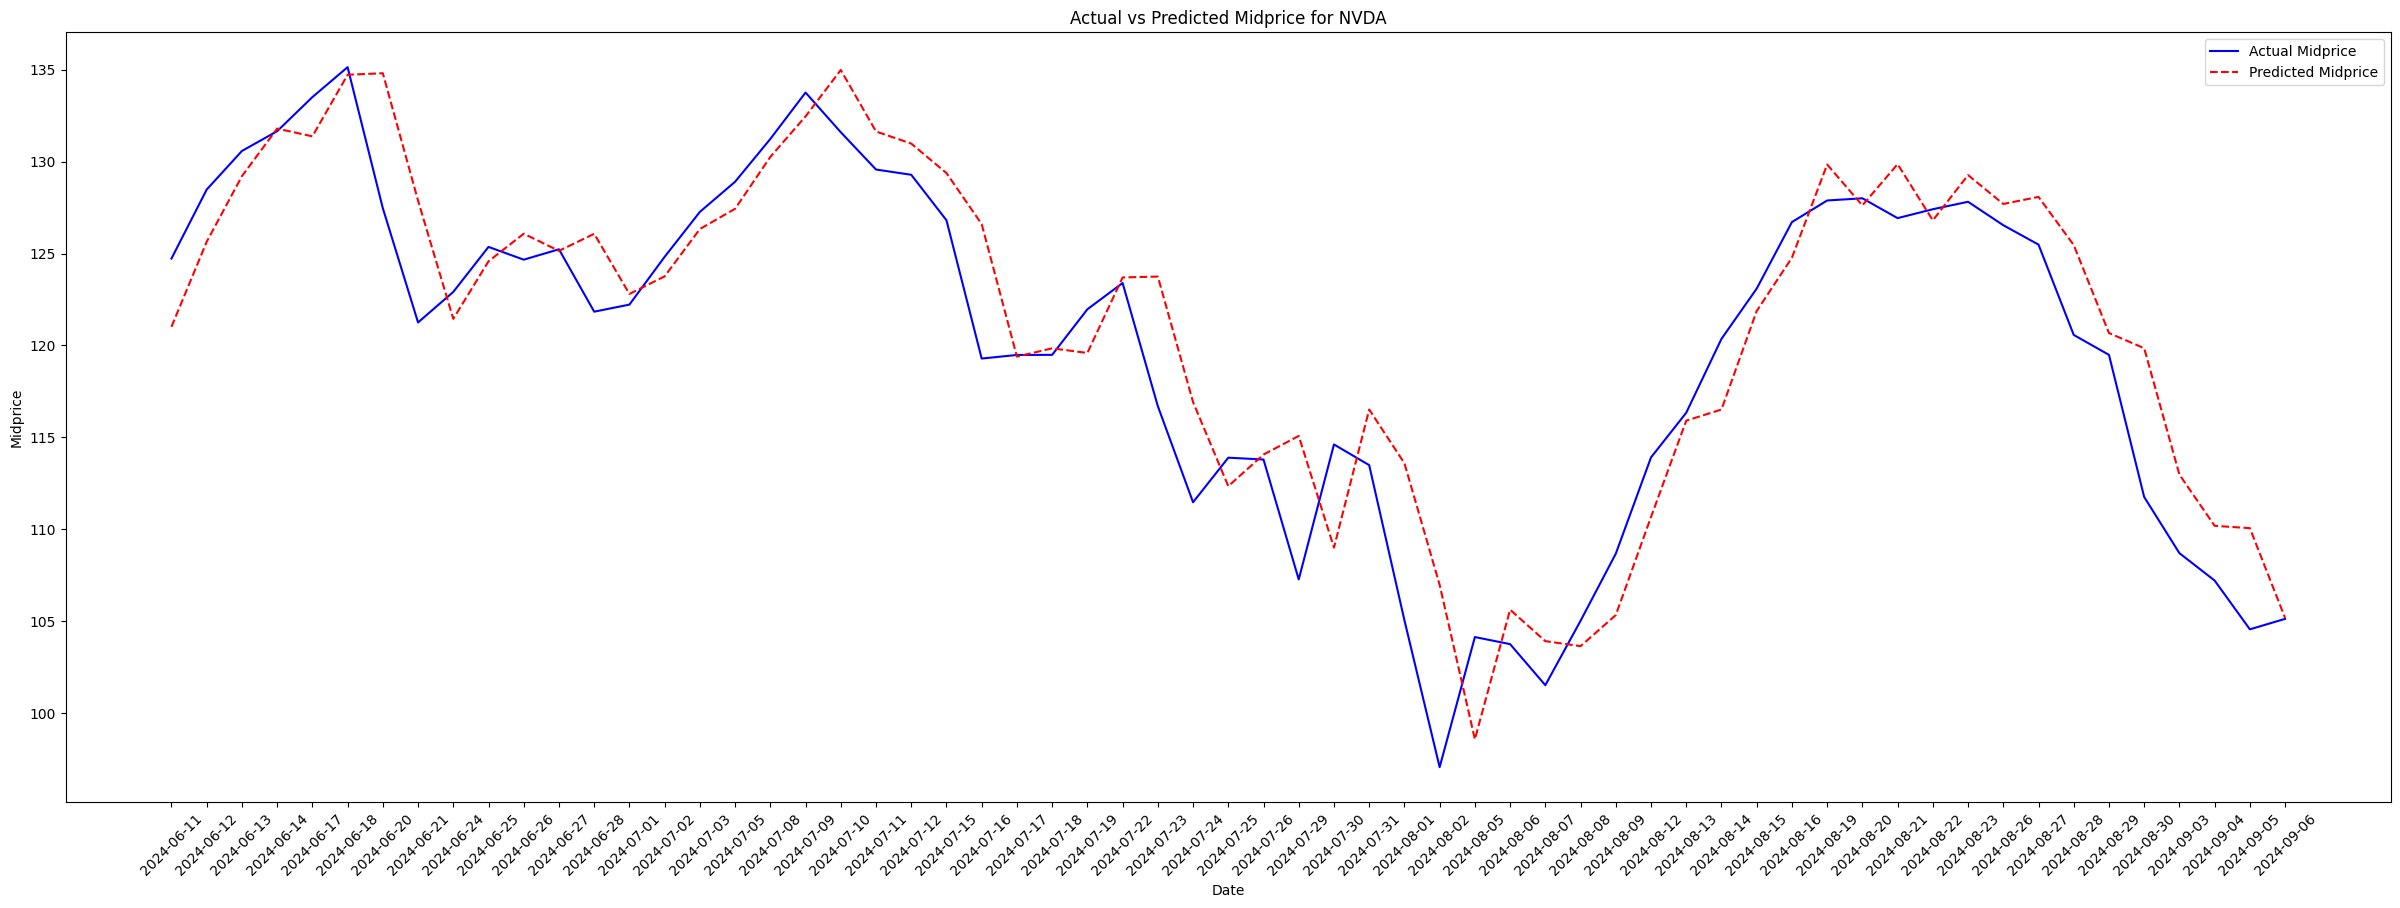

SGDUSD=X at 2024-06-12 , Actual Price: 0.0001456439495086, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1], final: [1.2724457e-05]
SGDUSD=X at 2024-06-13 , Actual Price: -0.0023589730262756, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1], final: [1.2724457e-05]
SGDUSD=X at 2024-06-14 , Actual Price: -7.605552673339844e-05, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1], final: [1.2724457e-05]
SGDUSD=X at 2024-06-17 , Actual Price: 1.7404556274414062e-05, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1], final: [1.2724457e-05]
SGDUSD=X at 2024-06-18 , Actual Price: 0.001173049211502, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1], final: [1.2724457e-05]
SGDUSD=X at 2024-06-19 , Actual Price: -0.0008939206600189, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1], final: [1.2724457e-05]
SGDUSD=X at 2024-06-20 , Actual Price: -0.0010221302509307, xbregressor_result: [1.2724457e-05], xbclassifier_result: [1]

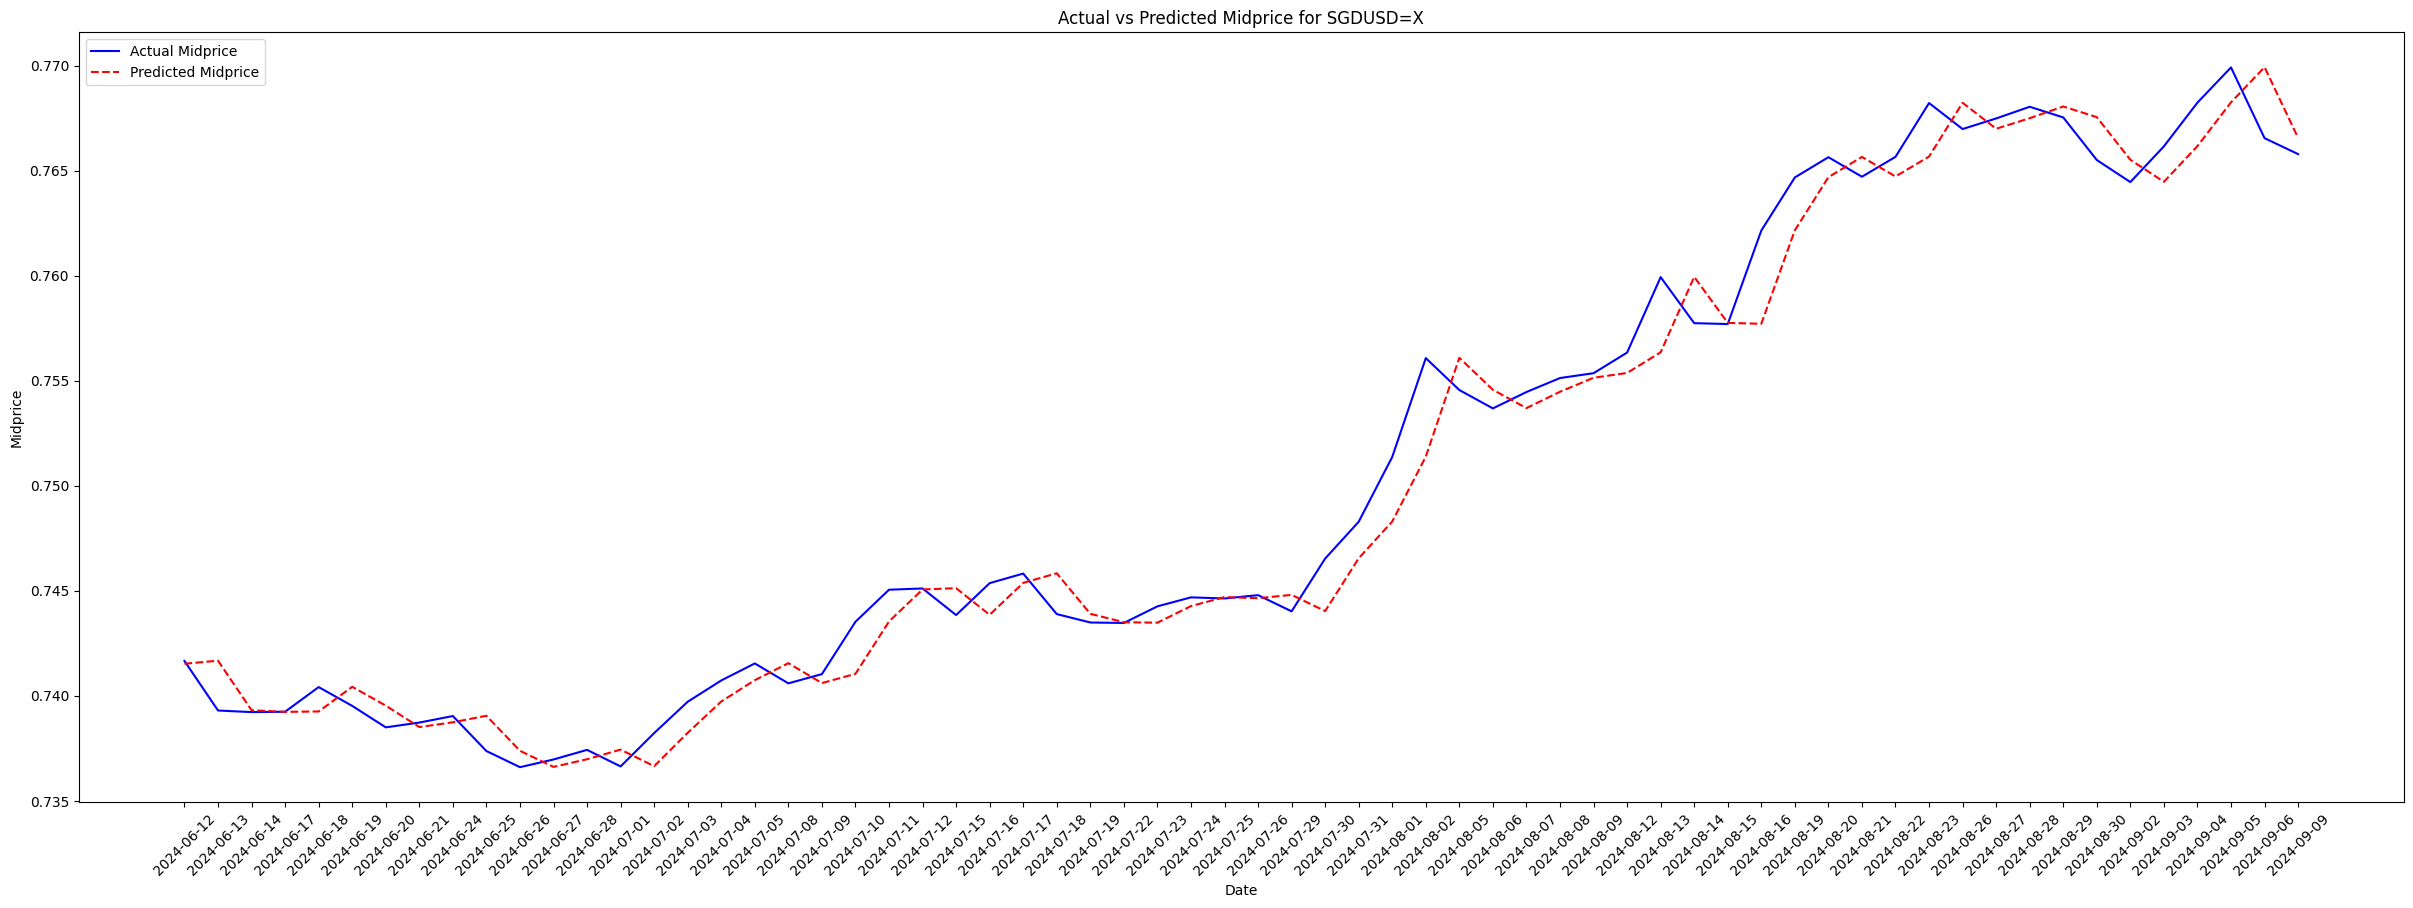

USDSGD=X at 2024-06-12 , Actual Price: -0.0002800226211547, xbregressor_result: [-2.265758e-05], xbclassifier_result: -1, final: [-2.265758e-05]
USDSGD=X at 2024-06-13 , Actual Price: 0.0043050646781921, xbregressor_result: [-2.265758e-05], xbclassifier_result: [1], final: [-2.265758e-05]
USDSGD=X at 2024-06-14 , Actual Price: 0.0001349449157714, xbregressor_result: [-2.265758e-05], xbclassifier_result: [1], final: [-2.265758e-05]
USDSGD=X at 2024-06-17 , Actual Price: -2.992153167724609e-05, xbregressor_result: [-2.265758e-05], xbclassifier_result: [1], final: [-2.265758e-05]
USDSGD=X at 2024-06-18 , Actual Price: -0.0021450519561767, xbregressor_result: [-2.265758e-05], xbclassifier_result: [1], final: [-2.265758e-05]
USDSGD=X at 2024-06-19 , Actual Price: 0.0016350150108337, xbregressor_result: [-2.265758e-05], xbclassifier_result: [1], final: [-2.265758e-05]
USDSGD=X at 2024-06-20 , Actual Price: 0.0018699765205383, xbregressor_result: [-2.265758e-05], xbclassifier_result: [1], fin

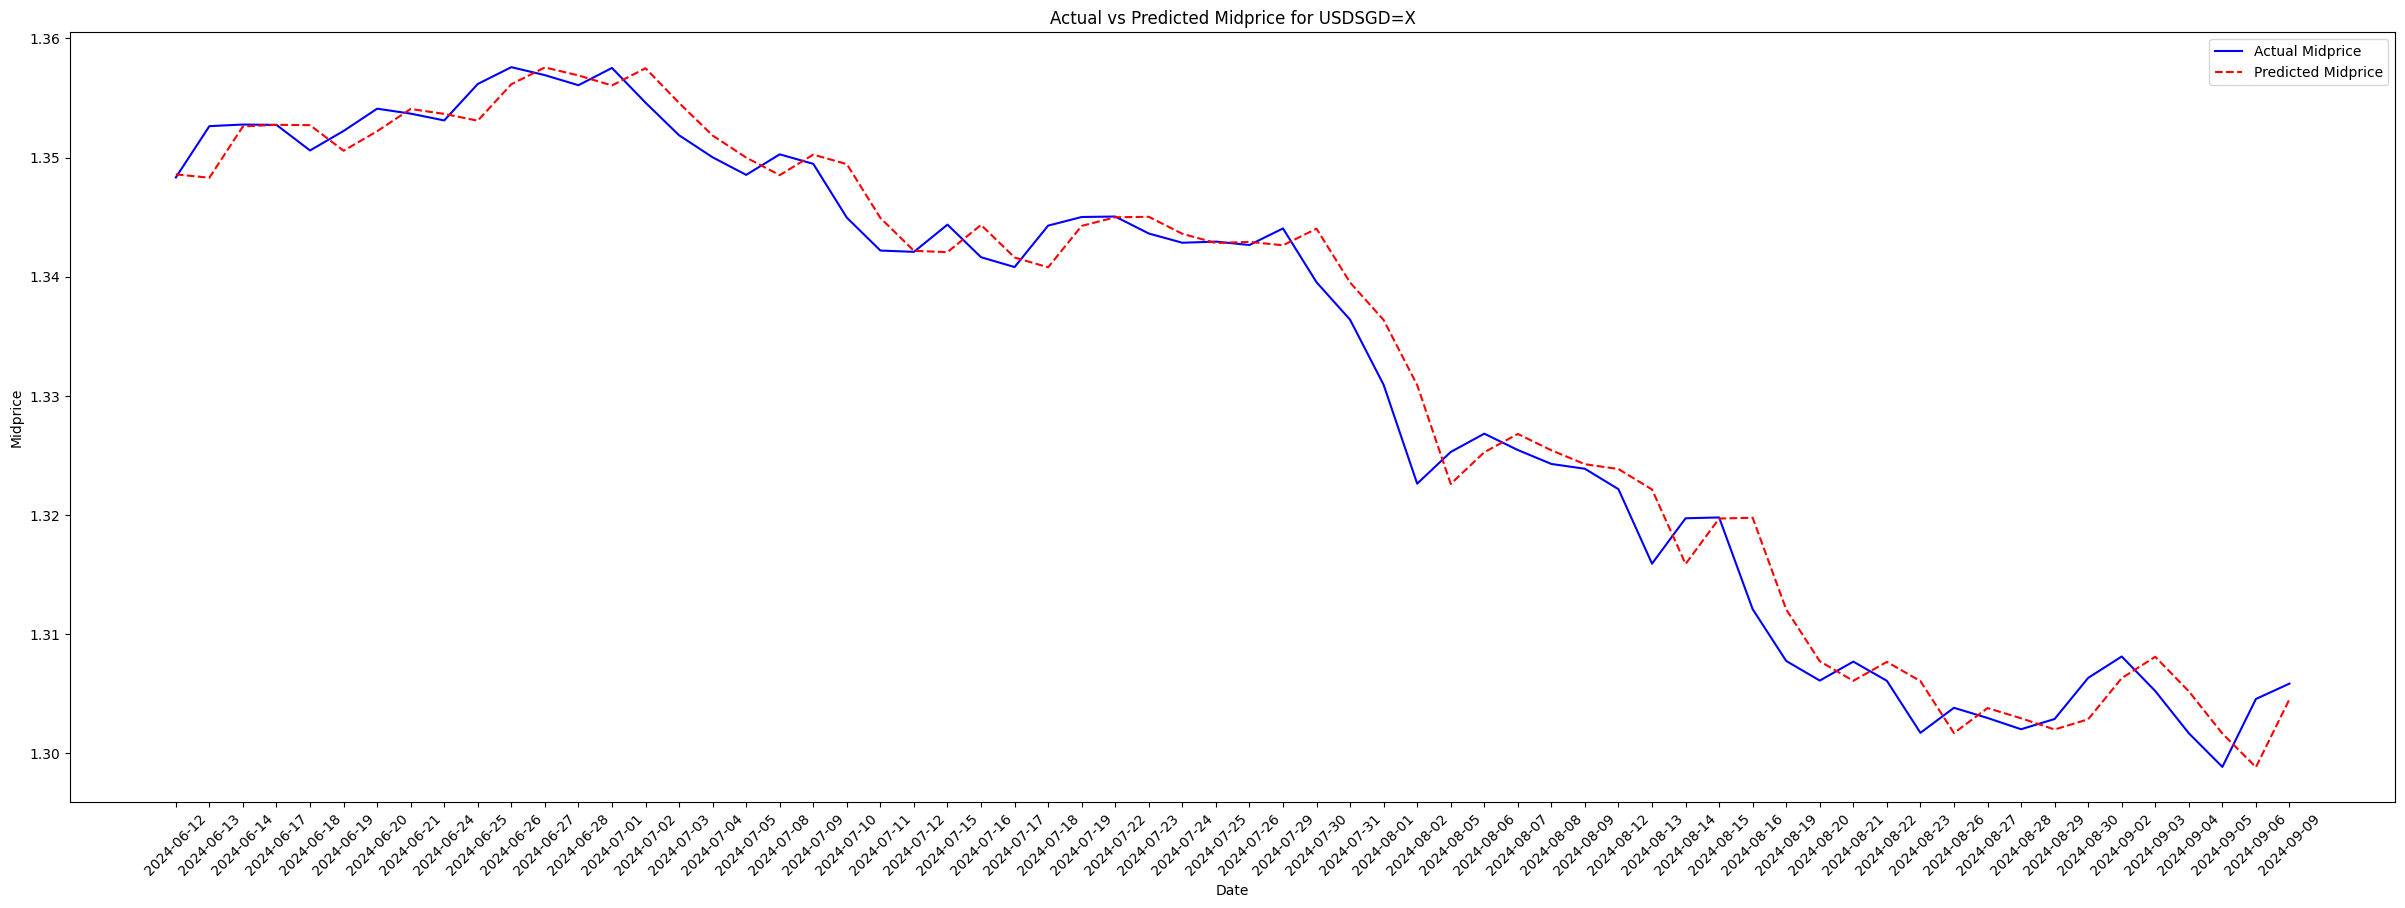

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary functions defined elsewhere:
# xbclassifier_predict, xbregressor_predict, root_mean_squared_error

for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/test/{ticker_symbol}.csv")
    X = dataframe.drop(columns=[
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ])

    sign_correct = 0
    total_predictions = 0
    actual_changes = []
    predicted_changes = []
    predicted_midprice = []

    # Loop through the dataframe starting from row 31 (index 30) to the second-to-last row
    for index, row in X.iloc[30:-1].iterrows():
        row_data = row.to_frame().T.reset_index(drop=True)  # Convert row to DataFrame and reset index
        
        xbclassifier_result = xbclassifier_predict(row_data, ticker_symbol)
        if xbclassifier_result == 0:
            xbclassifier_result = -1  # Adjust predicted_sign if it is 0
        
        xbregressor_result = xbregressor_predict(row_data, ticker_symbol)
        #predicted_value = abs(xbregressor_result) * xbclassifier_result
        predicted_value = xbregressor_result
        
        predicted_midprice.append(dataframe.iloc[index]['DAILY_MIDPRICE'] + predicted_value)

        actual_change = dataframe.iloc[index]['DAILY_MIDPRICE_CHANGE']
        actual_sign = np.sign(actual_change)
        
        # Collect actual and predicted changes for RMSE calculation
        actual_changes.append(actual_change)
        predicted_changes.append(predicted_value)

        #predicted_sign = xbclassifier_result
        predicted_sign = np.sign(xbregressor_result)
        
        # Check if the predicted sign matches the actual sign
        if predicted_sign == actual_sign:
            sign_correct += 1
        total_predictions += 1

        print(f"{ticker_symbol} at {dataframe.iloc[index]['Date']} , Actual Price: {actual_change}, xbregressor_result: {xbregressor_result}, xbclassifier_result: {xbclassifier_result}, final: {predicted_value}")

    # Calculate sign accuracy
    sign_accuracy = sign_correct / total_predictions
    print(f"{ticker_symbol} Sign Accuracy: {sign_accuracy}")

    # Calculate RMSE
    rmse = root_mean_squared_error(actual_changes, predicted_changes)
    print(f"{ticker_symbol} RMSE: {rmse}")

    # Predict the last entry
    last_row = X.iloc[-1].to_frame().T.reset_index(drop=True)
    last_xbclassifier_result = xbclassifier_predict(last_row, ticker_symbol)
    if last_xbclassifier_result == 0:
        last_xbclassifier_result = -1  # Adjust predicted_sign if it is 0
    
    last_xbregressor_result = xbregressor_predict(last_row, ticker_symbol)
    last_predicted_value = abs(last_xbregressor_result) * last_xbclassifier_result 

    print(f"{ticker_symbol} at {dataframe.iloc[-1]['Date']} , Predicted Price: {last_predicted_value}")

    # Plotting the results for each ticker
    plt.figure(figsize=(30, 10))

    # Plot actual midprice
    plt.plot(dataframe.iloc[31:-1]['Date'], dataframe.iloc[30:-1]['NEXT_DAY_MIDPRICE'], label='Actual Midprice', color='blue')

    # Plot predicted midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], predicted_midprice, label='Predicted Midprice', color='red', linestyle='--')

    # Add title and labels
    plt.title(f'Actual vs Predicted Midprice for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Midprice')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

